# Plots

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
bios_clean = pd.read_csv('clean-data/bios.csv')
# bios_clean.columns
# athlete_id, name, born_date, born_city, born_region, born_country, NOC, height_cm, weight_kg, died_date

bios_locs = pd.read_csv('clean-data/bios_locs.csv')
# bios_locs.columns
# athlete_id, name, born_date, born_city, born_region, born_country, NOC, height_cm, weight_kg, died_date, lat, long

noc_regions = pd.read_csv('clean-data/noc_regions.csv')
# noc_regions.columns
# NOC, region, notes

populations = pd.read_csv('clean-data/populations.csv')
# populations.columns
# Country Name, Country Code, Years...[1960-2023]

results = pd.read_csv('clean-data/results.csv')
# results.columns
# year, type, discipline, event, as, athlete_id, noc, team, place, tied, medal

unclean_bios = pd.read_csv('athletes/bios.csv')
# print(unclean_bios.columns)
# ['Roles', 'Sex', 'Full name', 'Used name', 'Born', 'Died', 'NOC',
#    'athlete_id', 'Measurements', 'Affiliations', 'Nick/petnames',
#    'Title(s)', 'Other names', 'Nationality', 'Original name',
#    'Name order']

unclean_results = pd.read_csv('results/results.csv')
# print(unclean_results.columns)
# ['Games', 'Event', 'Team', 'Pos', 'Medal', 'As', 'athlete_id', 
#     'NOC', 'Discipline', 'Nationality', 'Unnamed: 7']

# # Athlete with the most medals
# most_medals = results.groupby('as')['medal'].count().sort_values(ascending=False)
# # most_medals.head()

# # Countries with the most medals
# most_medals_country = results.groupby('noc')['medal'].count().sort_values(ascending=False)
# # most_medals_country.head()

/var/folders/qk/q1gqpdyj7m50xh7lmjvf8ds80000gn/T/ipykernel_34742/2613758453.py:28: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  unclean_results = pd.read_csv('results/results.csv')


### Country-name dictionary

In [4]:
# Make country abbreviation to country name dictionary
axes = noc_regions.sort_values(by='NOC', ascending=True)
noc_list = noc_regions['NOC'].values.tolist()
cnames = noc_regions['region'].values.tolist()
countries = dict(zip(noc_list, cnames))
countries['ROC'] = 'Russia'
countries['ROC']

'Russia'

### Number of athletes per country (top 20)

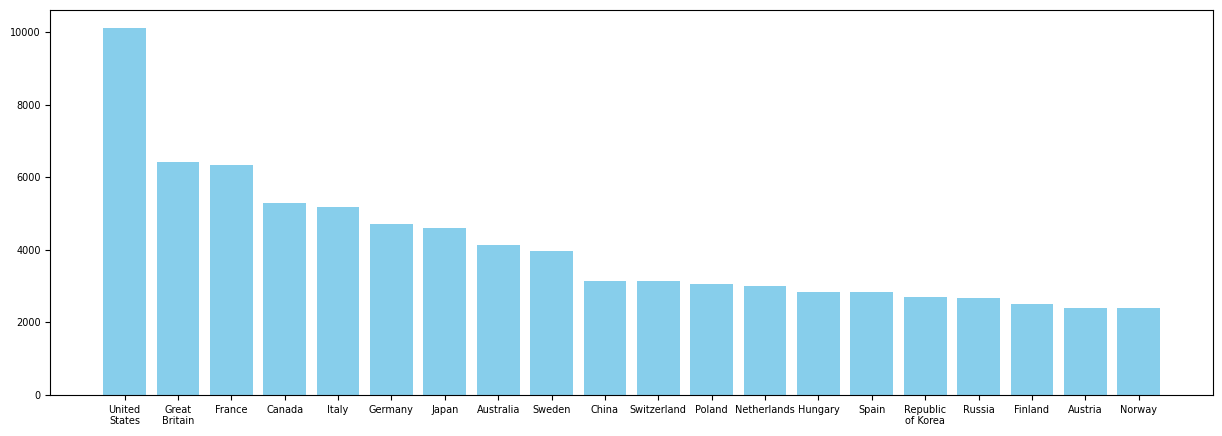

In [5]:
# Plot number of athletes per different country (matplotlib imported as plt, pandas imported as pd)

n = 20

# Take 20 countries with the most athletes for plotting
all = bios_clean['NOC'].value_counts()
single_national = all.sort_values(ascending=False)

# print(single_national.__contains__('Russia')) # Returns False => correct key name
single_national.rename(index={'Soviet Union' : 'Russia'}, inplace=True)
# print(single_national.__contains__('China')) # Returns False => correct key name
single_national.rename(index={'People\'s Republic of China' : 'China'}, inplace=True)

# Adapt key names for better visualisation
for key in single_national.head(n).keys():
    new_key = key.replace(' ', '\n')
    new_key = new_key.replace('of\n', 'of ')
    single_national.rename(index={key: new_key}, inplace=True)

# Set font size
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 7}
plt.rc('font', **font)

# Plot
fig, ax = plt.subplots()
ax.bar(single_national.head(n).index, single_national.head(n).values, color='skyblue')
fig.set_size_inches(15, 5)

### Number of medals per country (top 20)

Olympics from: 1896 - 2022


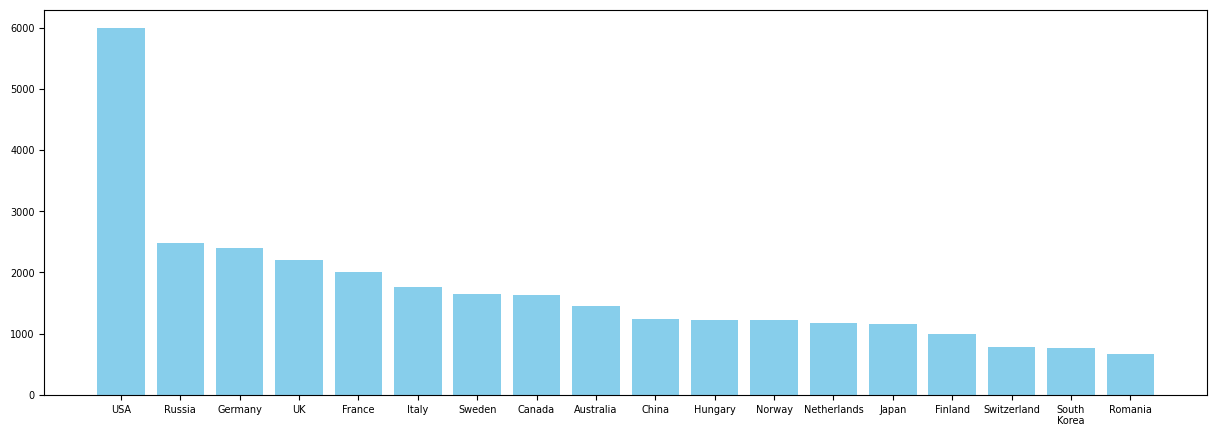

In [6]:
# Plot number of medals per country

n = 20

# Take 20 countries with the most medals for plotting
all_res = results.copy()
best = all_res.sort_values(by='medal', ascending=True)
only_medallists = best[(best['medal'] == 'Bronze') | (best['medal'] == 'Silver') | (best['medal'] == 'Gold')]

min_year = only_medallists['year'].min().astype(int)
max_year = only_medallists['year'].max().astype(int)
print(f"Olympics from: {min_year} - {max_year}")

# Count medals per country
medals = only_medallists['noc'].value_counts()
medals = medals.sort_values(ascending=False)

# Adapt key names for better visualisation
for key in medals.head(n).keys():
    new_key = countries[key]
    new_key = new_key.replace(' ', '\n')
    new_key = new_key.replace('of\n', 'of ')
    medals.rename(index={key: new_key}, inplace=True)

# Plot
fig_medals, ax_medals = plt.subplots()
ax_medals.bar(medals.head(n).index, medals.head(n).values, color='skyblue')
fig_medals.set_size_inches(15, 5)

### Number of medals and athletes per company by medal/athlete ratio (top 20)

Minimum number of athletes per city: 210


/var/folders/qk/q1gqpdyj7m50xh7lmjvf8ds80000gn/T/ipykernel_34742/2554078605.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  top_countries['noc'].replace(country, new_cname, inplace=True)


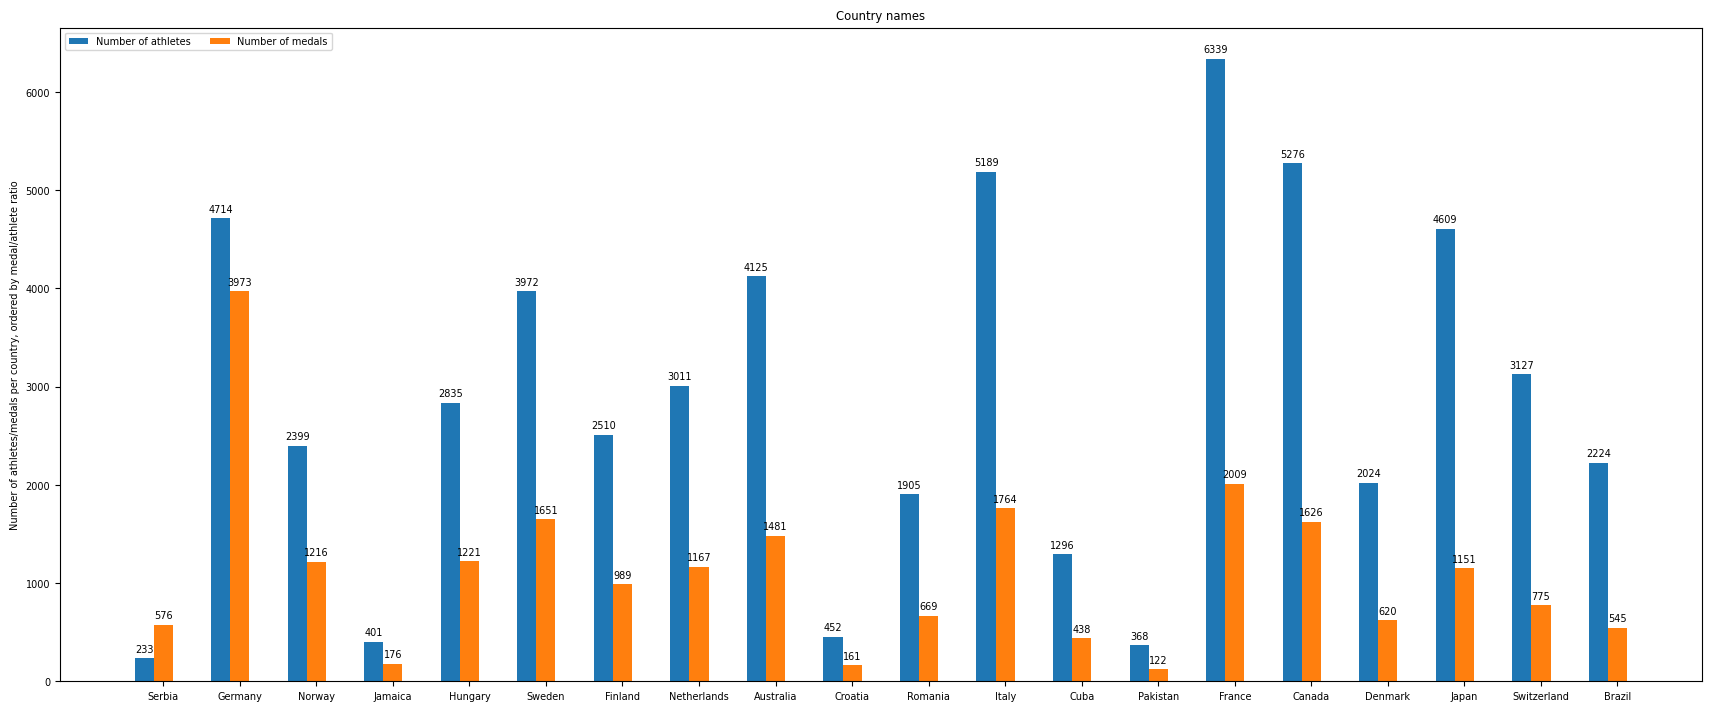

In [7]:
# Plot top 20 cities with best athletes/medallists ratio

n = 20

# Prepare DataFrames for merge
# Number of athletes
df_athletes = bios_clean['NOC'].value_counts().reset_index(name='num_athletes').sort_values(by='num_athletes', ascending=False)
df_athletes.rename(index={'Soviet Union' : 'Russia'}, inplace=True)
df_athletes.rename(index={'People\'s Republic of China' : 'China'}, inplace=True)

# BIG PROBLEM: Sometimes, the NOC ends up being the country name, sometimes it's the abbreviation. 
# To resolve this, we need to convert all NOCs to country names BEFORE counting the number of medals
# (the number of medals corresponds to the number of rows left, since each row corresponds to a medallist,
# because other athletes get filtered out in the very first step)

all_countries = noc_regions['region'].values.tolist()

# Number of medals per country
df_medallists = results[(results['medal'] == 'Gold') | (results['medal'] == 'Silver') | (results['medal'] == 'Bronze')]
df_medals = df_medallists.copy()

not_in_noc = ['SGP', 'LBN']
for noc in df_medals['noc']:
    if noc in not_in_noc or noc in all_countries:
        continue
    cname = countries[noc]
    df_medals.replace(noc, cname, inplace=True)
df_medals = df_medals.value_counts('noc').reset_index(name='num_medals')

# In case you want to check that each country figures only once in df_medals
# ctr = df_medals['noc']
# ctr2 = []
# for c in ctr:
#     if c in ctr2:
#         print(f"Error with {c}")
#     ctr2.append(c)


# Rename NOC column to noc for merge
df_athletes.rename(columns={'NOC': 'noc'}, inplace=True)

# Minimum number of athletes per city to be considered
min_athletes = df_athletes['num_athletes'].mean().__ceil__()
print(f"Minimum number of athletes per city: {min_athletes}")

# Merge DataFrames and create a new column "ratio" = medals / num_athletes
merged_nat_df = df_athletes.merge(df_medals, on="noc",how="inner") 
merged_nat_df["ratio"] = merged_nat_df["num_medals"] / merged_nat_df["num_athletes"]
top_countries = merged_nat_df[merged_nat_df["num_athletes"] >= min_athletes].sort_values(by='ratio', ascending=False)

# Adapt key names for better visualisation
for country in top_countries['noc'].head(n):
    new_cname = country.replace(' ', '\n')
    top_countries['noc'].replace(country, new_cname, inplace=True)

# Helper
def flatten(xss):
    return [x for xs in xss for x in xs]

# Plot

to_plot_names = ['Number of athletes', 'Number of medals']
country_list = top_countries['noc'].head(n).values.tolist()
country_stats = {
    to_plot_names[0] : flatten(top_countries[['num_athletes']].head(n).values.tolist()),
    to_plot_names[1] : flatten(top_countries[['num_medals']].head(n).values.tolist())
}

x = np.arange(n)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in country_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of athletes/medals per country, ordered by medal/athlete ratio')
ax.set_title('Country names')
ax.set_xticks(x + width, country_list)
ax.legend(loc='upper left', ncols=len(to_plot_names))
fig.set_size_inches(17, 7)

plt.show()

### Number of American athletes per birthplace (top 20)

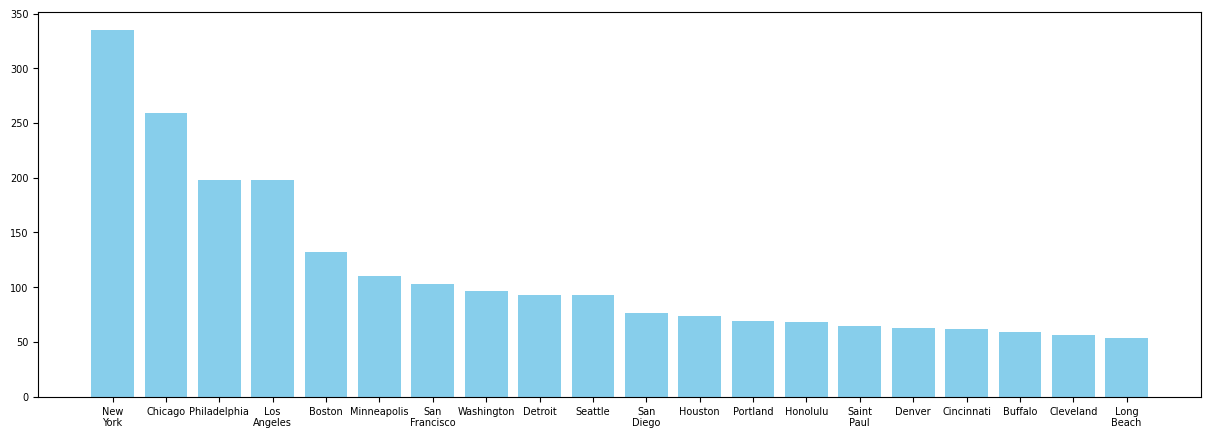

In [8]:
# Plot 20 most common birthplaces of American athletes

n = 20

# Take only data from USA
usa_data = bios_clean[bios_clean['NOC'] == 'United States'].sort_values(by='born_city', ascending=True)

# There exist multiple athletes with the same name, but they are not the same people added twice by accident so it is not a problem
# usa_data_by_name = usa_data['name'].value_counts().sort_values(ascending=False).head(10).keys().tolist()
# # display(usa_data_by_name)
# display((usa_data[usa_data['name'].isin(usa_data_by_name)]).sort_values(by='name', ascending=True))

# Count athletes per city
cities = usa_data['born_city'].value_counts().sort_values(ascending=False)

# Adapt key names for better visualisation
for key in cities.head(n).keys():
    new_key = key.replace(' ', '\n')
    cities.rename(index={key: new_key}, inplace=True)

# Plot
fig_cities, ax_cities = plt.subplots()
ax_cities.bar(cities.head(n).index, cities.head(n).values, color='skyblue')
fig_cities.set_size_inches(15, 5)

us_cities1 = cities.head(n).keys().tolist()

### Number of American medals per birthplace (top 20)

/var/folders/qk/q1gqpdyj7m50xh7lmjvf8ds80000gn/T/ipykernel_34742/2114290318.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  medals_per_city['born_city'].replace(city, new_cname, inplace=True)


'Weak' cities: ['Minneapolis', 'Saint\nPaul', 'Denver', 'Buffalo']

'Strong' cities ['Baltimore', 'Madison', 'Oakland', 'Pittsburgh']


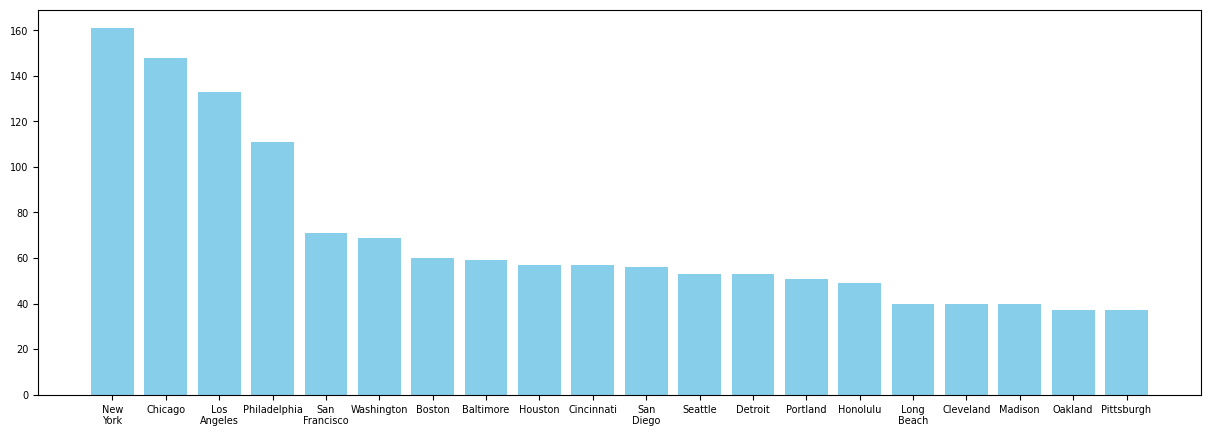

In [9]:
# Plot 20 most common birthplaces of American athletes

n = 20

# Take only data from USA
usa_medallists = results[results['noc'] == 'USA']
usa_medallists = usa_medallists[(usa_medallists['medal'] == 'Gold') | (usa_medallists['medal'] == 'Silver') | (usa_medallists['medal'] == 'Bronze')]

# Create dictionary lookup for athlete_id to birthplace
ids = usa_medallists['athlete_id'].values.tolist()
birthplaces = {}
for id in ids:
    birthplaces[id] = bios_locs[bios_locs['athlete_id'] == id]['born_city'].values[0]

# Map birthplaces to athlete_id in medallists DataFrame
usa_medallists['born_city'] = usa_medallists['athlete_id'].map(birthplaces)

# Count medals per city
medals_per_city = (usa_medallists.groupby('born_city').size().reset_index(name='medals').sort_values('medals', ascending=False))

# Adapt key names for better visualisation
for city in medals_per_city.head(n)['born_city']:
    new_cname = city.replace(' ', '\n')
    medals_per_city['born_city'].replace(city, new_cname, inplace=True)

# Plot
fig_medals, ax_medals = plt.subplots()
ax_medals.bar(medals_per_city['born_city'].head(n), medals_per_city['medals'].head(n), color='skyblue')
fig_medals.set_size_inches(15, 5)

us_cities2 = medals_per_city['born_city'].head(n).values.tolist()
# Cities in the top 20 of most common birthplaces of American athletes not in top 20 of cities with most medals
diff1 = [value for value in us_cities1 if not value in us_cities2]
# Cities in the top 20 of cities with most medals not in top 20 of most common birthplaces of American athletes
diff2 = [value for value in us_cities2 if not value in us_cities1]
print(f"\'Weak\' cities: {diff1}\n")
print(f"\'Strong\' cities {diff2}")

### Best cities relative to number of athletes competing (top 20)

/var/folders/qk/q1gqpdyj7m50xh7lmjvf8ds80000gn/T/ipykernel_34742/780602411.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  top_cities['born_city'].replace(city, new_cname, inplace=True)


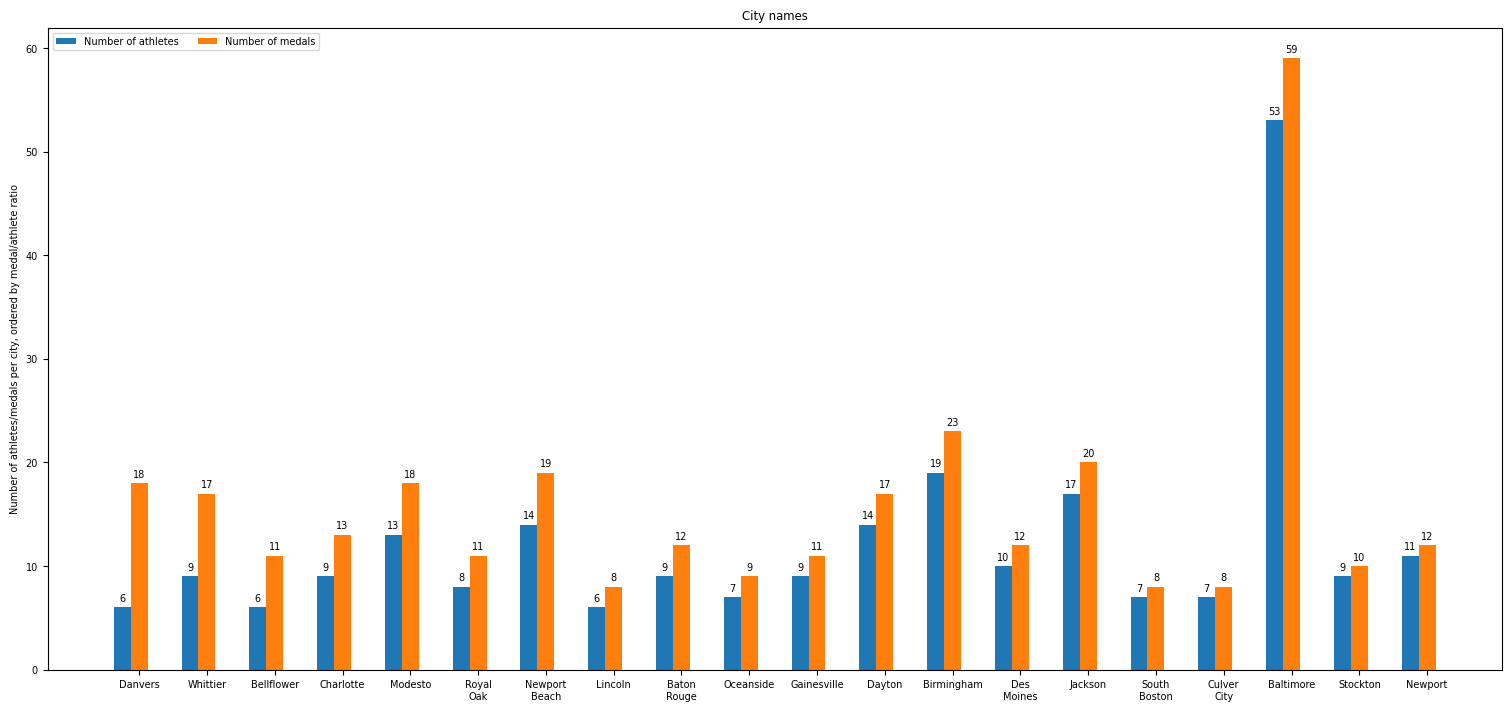

In [11]:
# Plot top 20 cities with best athletes/medallists ratio

n = 20

# Count athletes to medallists ratio for each city
df_cities = cities.reset_index(name='num_athletes')

# Minimum number of athletes per city to be considered
min_athletes = 6 # df_cities['num_athletes'].mean().__ceil__()
# print(f"Minimum number of athletes per city: {min_athletes}")

# Merge DataFrames and create a new column "ratio" = medals / num_athletes
merged_df = df_cities.merge(medals_per_city, on="born_city",how="inner")
merged_df["ratio"] = merged_df["medals"] / merged_df["num_athletes"]
top_cities = merged_df[merged_df["num_athletes"] >= min_athletes].sort_values(by='ratio', ascending=False)

# Adapt key names for better visualisation
for city in top_cities['born_city'].head(n):
    new_cname = city.replace(' ', '\n')
    top_cities['born_city'].replace(city, new_cname, inplace=True)

# Helper
def flatten(xss):
    return [x for xs in xss for x in xs]

# Plot

to_plot_names = ['Number of athletes', 'Number of medals']

city_list = top_cities['born_city'].head(n).values.tolist()
city_stats = {
    to_plot_names[0] : flatten(top_cities[['num_athletes']].head(n).values.tolist()),
    to_plot_names[1] : flatten(top_cities[['medals']].head(n).values.tolist())
}

x = np.arange(n)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in city_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of athletes/medals per city, ordered by medal/athlete ratio')
ax.set_title('City names')
ax.set_xticks(x + width, city_list)
ax.legend(loc='upper left', ncols=len(to_plot_names))
fig.set_size_inches(15, 7)

plt.show()

### Evolution of the proportion of women to men over the years

Olympics from: 1888 - 2022


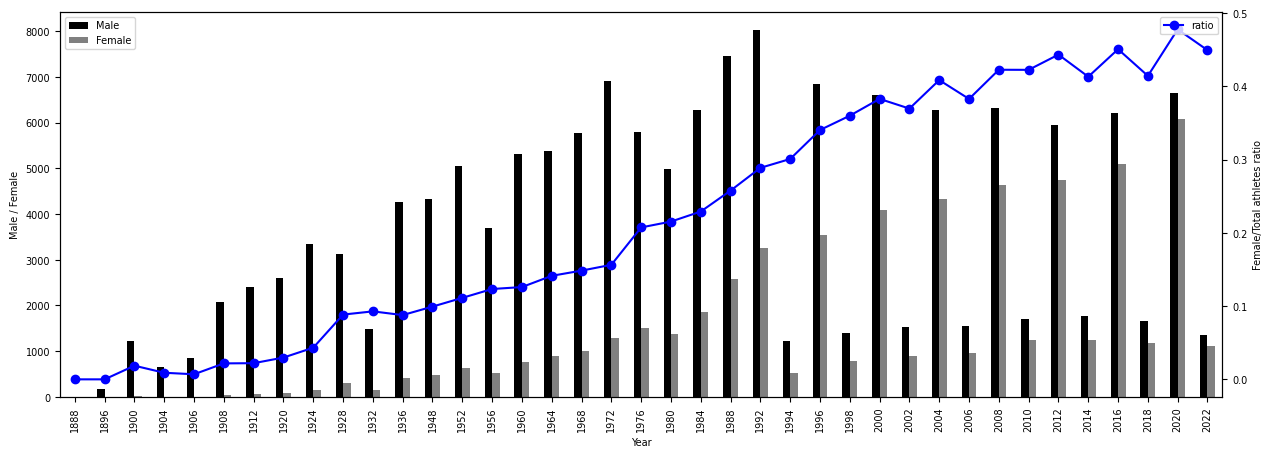

In [12]:
gender_info = unclean_bios.copy().drop(columns=['Roles', 'Full name', 'Used name', 'Born', 'Died', 'NOC', 
    'Measurements', 'Affiliations', 'Nick/petnames', 'Title(s)', 'Other names', 'Nationality', 'Original name', 'Name order'])
# display(gender_info.head())

# Columns: ['Roles', 'Sex', 'Full name', 'Used name', 'Born', 'Died', 'NOC', 
# 'athlete_id', 'Measurements', 'Affiliations', 'Nick/petnames',
# 'Title(s)', 'Other names', 'Nationality', 'Original name', 'Name order']

games_info = unclean_results.copy().drop(columns=['Unnamed: 7', 'Team', 'As', 'NOC', 'Discipline', 'Nationality', 'Pos', 'Medal', 'Event'])
# display(games_info.head())

# Columns: ['Games', 'Event', 'Team', 'Pos', 'Medal', 'As', 'athlete_id', 'NOC', 
# 'Discipline', 'Nationality', 'Unnamed: 7']

# Parse out year from games column
games_info['year'] = games_info['Games'].str.extract(r'(\d{4})')
games_info.drop(columns=['Games'], inplace=True)

# Merge DataFrames on athlete_id
df_merged = games_info.merge(gender_info, on='athlete_id', how='inner')

# Now need to remove when athlete is contained multiple times per year,
# but since each row should be unique, we can just drop duplicates
df_merged.drop_duplicates(inplace=True)

# Count number of male and female athletes per year
mw_per_year = df_merged.groupby(['year', 'Sex']).size().unstack(fill_value=0).reset_index()
mw_per_year.rename_axis(None, axis=1, inplace=True)

# Add total athletes per year and then the ratio
mw_per_year['ratio'] = mw_per_year['Female'] / (mw_per_year['Female'] + mw_per_year['Male'])

min_year = mw_per_year['year'].min()
max_year = mw_per_year['year'].max()
print(f"Olympics from: {min_year} - {max_year}")

# Plot the bars with a pandas.DataFrame.plot and assign the plot to ax
ax = mw_per_year.plot.bar(x='year', y=['Male', 'Female'], ylabel='Male / Female', xlabel='Year', color=['black', 'gray'], figsize=(15, 5))

# Create ax2
ax2 = ax.twinx()

# Plot the lines
mw_per_year.plot(x='year', y=['ratio'], marker='o', ylabel='Female/Total athletes ratio', color=['blue', 'lightblue'], ax=ax2)

# locate the legend
ax.legend(loc="upper left")
ax2.legend(loc='upper right')

plt.show()